This notebook plots the solutions. You can actually plot the progress while the solver is running to see if it makes sense.

Various imports:

In [1]:


%load_ext autoreload
%autoreload 2
# add path to code
import sys, os
sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')
import numpy as np
from matplotlib.tri import Triangulation
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import importlib
from post_process import dofs_to_serial
from load_lakes import gdf
import topotoolbox as tt3
from params import rho_w,g
from dolfinx.fem import locate_dofs_topological
from dolfinx.mesh import locate_entities_boundary
from scipy.stats import linregress

In [2]:
# set the results to load
resultsname = '../results/cooke2_N340kpa_store'

In [3]:
# load the setup module for that experiment
sys.path.insert(0, resultsname)
py_file = [f for f in os.listdir(resultsname) if f.endswith('.py')][0]
path = os.path.join(resultsname, py_file)
spec = importlib.util.spec_from_file_location("my_module", path)
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

lake_bdry = setup.lake_bdry.x.array # get lake boundary

# create triangulation for matplotlib plotting that mirrors the mesh triangulation.
triang = Triangulation(setup.domain.geometry.x[:,0]/1e3,setup.domain.geometry.x[:,1]/1e3,setup.domain.geometry.dofmap)
N_bdry = setup.N_bdry
lake_name = setup.lake_name

Info    : Reading '../meshes/Cook_E2_mesh.msh'...
Info    : 253 entities
Info    : 3666 nodes
Info    : 7092 elements
Info    : Done reading '../meshes/Cook_E2_mesh.msh'


In [4]:
t = np.load(resultsname+'/t.npy')
nodes_x = np.load(resultsname+'/nodes_x.npy')
nodes_y = np.load(resultsname+'/nodes_y.npy')

# create map from parallel dof numbering to serial dof numbering
nodes_parallel = np.column_stack((nodes_x,nodes_y))
nodes_serial = setup.domain.geometry.x[:,0:2]
map_dofs = dofs_to_serial(nodes_parallel,nodes_serial)

In [5]:
# load results and reorder dof's to the serial ordering
N = np.load(resultsname+'/N.npy')[:,map_dofs]
b = np.load(resultsname+'/b.npy')[:,map_dofs]
qx = np.load(resultsname+'/qx.npy')[:,map_dofs]
qy = np.load(resultsname+'/qy.npy')[:,map_dofs]

# get water flow speed
q_m = np.sqrt(qx**2+qy**2)

In [6]:
# get mean of N over the lake and max of q not over the lake
N_mean = np.zeros(t.size)
b_mean = np.zeros(t.size)
q_max = np.zeros(t.size)

j_max=0

for j in range(t.size):
    if np.max(q_m[j,:]>1e-10):
        N_j = N[j,:]
        b_j = b[j,:]
        q_j = q_m[j,:]
        
        if np.max(lake_bdry)>1e-10:
            # if storage take mean of pressure over lake area
            # and max of disharge 
            N_mean[j] = np.mean(N_j[lake_bdry>1e-2])
            b_mean[j] = np.mean(b_j[lake_bdry>1e-2])
            q_max[j] = np.max(q_j[lake_bdry<1e-2])

        else:
            # if no storage, just take mean over whole domain
            N_mean[j] = np.mean(N_j)
            b_mean[j] = np.mean(b_j)
            q_max[j] = np.max(q_j)

            
        j_max+=1 
j_max -= 1

In [7]:
# get dem for topotoolbox plotting
dem = tt3.read_tif('potenetial_dem_plotting.tif')
fd = tt3.FlowObject(dem)
s   = tt3.StreamObject(fd,threshold=2000,units='pixels')

In [8]:
storage = setup.lake_bdry.x.array
if setup.storage == False:
    storage *= 0 

In [9]:
# storage in the lake
b_L = -(N_mean-N_mean[0])/(rho_w*g)

In [10]:
facets_outflow = locate_entities_boundary(setup.domain, setup.domain.topology.dim-1, setup.OutflowBoundary)
outflow_dofs = locate_dofs_topological(setup.V0, setup.domain.topology.dim-1, facets_outflow)

mkdir: ../results/cooke2_N340kpa_store/movie: File exists


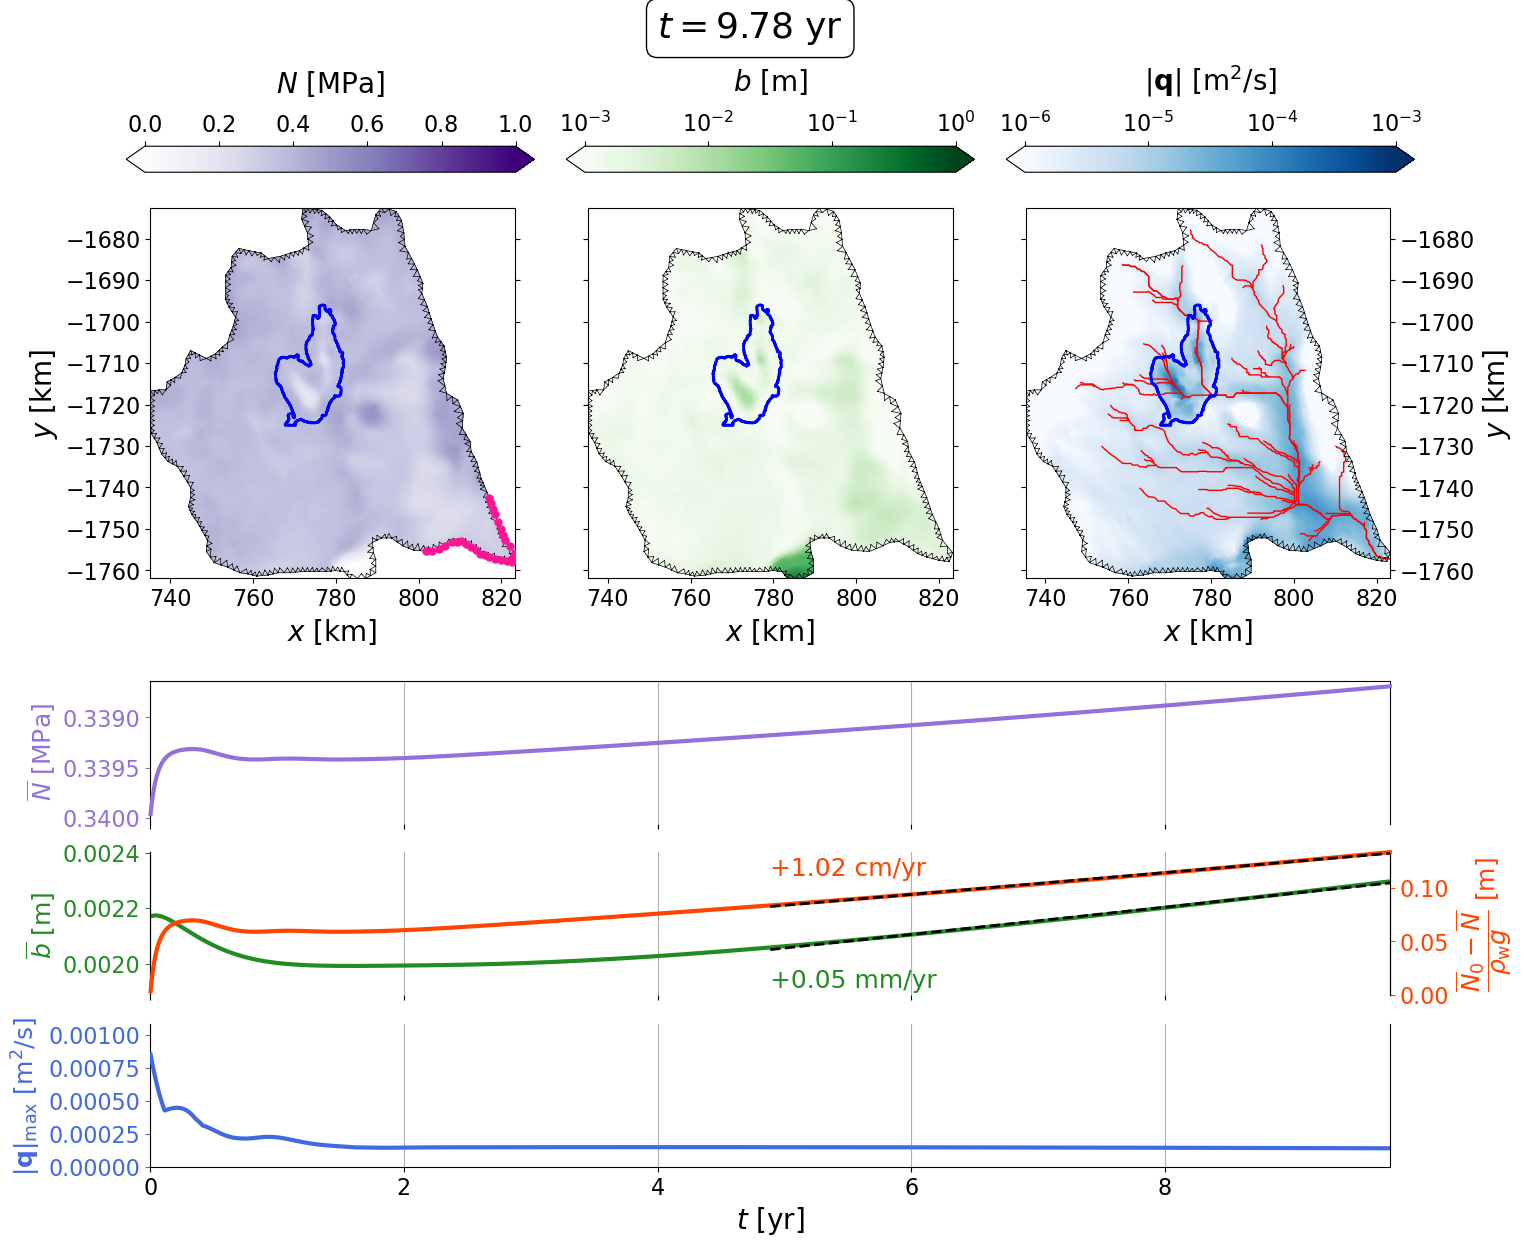

In [13]:
# NOTE:  working on 3-panel plot here
# choose to plot a single timestep OR a sequence to make a movie
ind = [j_max]               # plot a single time step
# ind = np.arange(1,j_max,1) # plot every time step for saving a movie

# make clean movie directory
# !rm -rf {resultsname}/movie
!mkdir {resultsname}/movie

if lake_name != 'none':
    outline = gdf.loc[gdf['name']==lake_name]

j=0

if len(ind)>1:
# use agg backend for saving pngs
    mpl.use('agg')
else:
    %matplotlib inline

triang_bdry = Triangulation(triang.x,triang.y,triang.triangles)
mask = np.all(triang_bdry.neighbors >= 0, axis=1)
triang_bdry.set_mask(mask)



qlim2 = np.floor(np.log10(np.max(q_m)))
qlim1 = np.floor(np.log10(np.mean(q_m[:,1:j_max])))

t_scale = 1.0 # 1 for years, 365 for days
if int(t_scale)==365:
    t_str = 'd' 
elif int(t_scale)==1:
    t_str = 'yr'
slope, intercept, r_value, p_value, std_err = linregress(t[int(0.5*(j_max)):j_max]*(t_scale/3.154e7), b_L[int(0.5*(j_max)):j_max])

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(t[int(0.5*(j_max)):j_max]*(t_scale/3.154e7), b_mean[int(0.5*(j_max)):j_max])


for i in ind:
    print('saved image '+str(j+1)+' out of '+str(len(ind))+' \r',end='')
    
    fig = plt.figure(figsize=(16,13))
    
    plt.suptitle(r'$t=$'+'{:.2f}'.format(t_scale*t[i]/3.154e7)+f' {t_str}',y=1.0,fontsize=26,bbox=dict(boxstyle='round', facecolor='w', alpha=1))

    ax1 = plt.subplot(231)
    N_i = N[i]
    plt.triplot(triang_bdry,linewidth=0.5,color='k',alpha=1,zorder=100)
    p1 = plt.tricontourf(triang,N_i/1e6,levels=np.linspace(0,1,100),cmap='Purples',extend='both')
    if lake_name != 'none':
        outline.plot(edgecolor='b',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=2,zorder=100,alpha=1)  
    else:
        plt.tricontour(triang,lake_bdry,levels=[0.001],colors='k',linestyles='-',linewidths=2)
    plt.plot(setup.domain.geometry.x[outflow_dofs,0]/1e3,setup.domain.geometry.x[outflow_dofs,1]/1e3,'o',markersize=5,color='deeppink',zorder=100)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$x$ [km]',fontsize=20)
    plt.ylabel(r'$y$ [km]',fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', which='both', labelright=False, right=True)
    cbar_ax = fig.add_axes([0.11, 0.875, 0.255, 0.02])
    cbar = plt.colorbar(p1,orientation='horizontal',ticks=np.linspace(0,1,6),cax=cbar_ax)
    cbar.set_label(r'$N$ [MPa]',fontsize=20,labelpad=15)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    plt.subplot(232)
    b_i = b[i]
    b_full = b_i #+ storage*(N_mean[i]-N_mean[0])/(rho_w*g)
    plt.triplot(triang_bdry,linewidth=0.5,color='k',alpha=1,zorder=100)
    p1 = plt.tricontourf(triang,b_full,cmap='Greens',extend='both',norm=colors.LogNorm(),levels=np.logspace(-3,0,100))
    if lake_name != 'none':
        outline.plot(edgecolor='b',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=2,zorder=100,alpha=1)  
    else:
        plt.tricontour(triang,lake_bdry,levels=[0.001],colors='k',linestyles='-',linewidths=2)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$x$ [km]',fontsize=20)
    plt.gca().tick_params(axis='y', which='both', labelright=False, right=True)
    plt.xticks(fontsize=16)
    plt.gca().yaxis.set_ticklabels([])
    cbar_ax = fig.add_axes([0.385, 0.875, 0.255, 0.02])
    cbar = plt.colorbar(p1,orientation='horizontal',ticks=np.logspace(-3,0,4),cax=cbar_ax)
    cbar.set_label(r'$b$ [m]',fontsize=20,labelpad=15)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    ax3 = plt.subplot(233)
    q_i = q_m[i]
    plt.triplot(triang_bdry,linewidth=0.5,color='k',alpha=1,zorder=100)
    p2 = plt.tricontourf(triang,q_i,cmap='Blues',extend='both',norm=colors.LogNorm(),levels=np.logspace(qlim1,qlim2,100))
    if lake_name != 'none':
        outline.plot(edgecolor='b',linestyle='-',facecolor='none',ax=plt.gca(),linewidth=2,zorder=100,alpha=1)  
    else:
        plt.tricontour(triang,lake_bdry,levels=[0.001],colors='k',linestyles='-',linewidths=2)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$x$ [km]',fontsize=20)
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.ylabel(r'$y$ [km]',fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', which='both', labelleft=False, left=True)
    
    #------- stream plot ------------
    xtix = ax3.get_xticks()
    ytix = ax3.get_yticks()
    xlim = ax3.get_xlim()
    ylim = ax3.get_ylim()

    dem.plot(ax3,cmap="terrain",alpha=0) 
    (s.klargestconncomps(1)).plot(ax=ax3,color='r',linewidth=1)
    (s.klargestconncomps(1).trunk()).plot(ax=ax3,color='r',linewidth=1)
    ax3.invert_yaxis()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax3.tick_params(axis='y', which='both', labelleft=False, left=True)
    ax3.set_xticks(xtix)
    ax3.set_yticks(ytix)
    ax3.set_xlim(xlim)
    ax3.set_ylim(ylim)
    #-------------------------------
    cbar_ax = fig.add_axes([0.66, 0.875, 0.255, 0.02])
    cbar = plt.colorbar(p2,cax=cbar_ax,orientation='horizontal',ticks=np.logspace(qlim1,qlim2,1+int(np.abs(qlim2-qlim1))))#,format='%.0e')
    cbar.set_label(r'$|\mathbf{q}|$ [m$^2/$s]',fontsize=20,labelpad=15)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    
    plt.subplot(614)
    line0, = plt.plot(t[1:i]*t_scale/3.154e7,(N_mean[1:i])/1e6,color='mediumpurple',linestyle='-',linewidth=3,zorder=100)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', colors="mediumpurple")
    plt.ylabel(r'$\overline{N}$ [MPa]',fontsize=18,color='mediumpurple')
    plt.ylim((N_mean[0:j_max].max()+0.25*np.std(N_mean[0:j_max]))/1e6,(N_mean[0:j_max].min()-0.25*np.std(N_mean[0:j_max]))/1e6)
    plt.xlim(0,t[j_max]*t_scale/3.154e7)
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().spines['bottom'].set_visible(False)
    plt.grid(axis='x')
    line0.set_clip_on(False)
    
    plt.subplot(616)
    plt.plot(t[1:i]*t_scale/3.154e7,q_max[1:i],color='royalblue',linewidth=3,zorder=10) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', colors="royalblue")
    plt.ylabel(r'$|\mathbf{q}|_\mathrm{max}$ [m$^2$/s] ',fontsize=18,color='royalblue')
    plt.xlim(0,t[j_max]*t_scale/3.154e7)
    plt.ylim(0,q_max.max()+0.1*np.std(q_max))
    plt.gca().spines['top'].set_visible(False)
    plt.grid(axis='x')
    plt.xlabel(r'$t$ [yr]',fontsize=20)

    ax4 = plt.subplot(615)
    plt.plot(t[1:i]*t_scale/3.154e7,b_mean[1:i],color='forestgreen',linewidth=3,zorder=10) 
    if setup.storage == True:
        t_apprx2 = t[int(0.5*(j_max)):j_max]*t_scale/3.154e7
        apprx2 = slope2*t[int(0.5*(j_max)):j_max]*(t_scale/3.154e7)+intercept2
        if i>int(0.5*(j_max)):
            plt.plot(t_apprx2[0:i-int(0.5*(j_max))],apprx2[0:i-int(0.5*(j_max))],linewidth=2,color='k',linestyle='--',zorder=100)
        if i>int(0.75*(j_max)):
            plt.annotate(f'{slope2*1e3:+.2f} mm/{t_str}',xy=(t_apprx2[0],apprx2[0]-2*np.std(apprx2)),fontsize=18,color='forestgreen')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', colors="forestgreen")
    plt.ylabel(r'$\overline{b}$ [m] ',fontsize=18,color='forestgreen')
    plt.xlim(0,t[j_max]*t_scale/3.154e7)
    plt.ylim(b_mean[0:j_max].min()-0.1*np.std(b_mean),b_mean.max()+0.1*np.std(b_mean))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.grid(axis='x')
    plt.gca().xaxis.set_ticklabels([])
    
    if setup.storage == True:
        ax5 = ax4.twinx()
        t_apprx = t[int(0.5*(j_max)):j_max]*t_scale/3.154e7
        apprx = slope*t[int(0.5*(j_max)):j_max]*(t_scale/3.154e7)+intercept
        line1, = plt.plot(t[1:i]*t_scale/3.154e7,b_L[1:i],color='orangered',linewidth=3,zorder=10) 
        if i>int(0.5*(j_max)):
            plt.plot(t_apprx[0:i-int(0.5*(j_max))],apprx[0:i-int(0.5*(j_max))],linewidth=2,color='k',linestyle='--',zorder=100)
        if i>int(0.75*(j_max)):
            plt.annotate(f'{slope*1e2:+.2f} cm/{t_str}',xy=(t_apprx[0],apprx[0]+2*np.std(apprx)),fontsize=18,color='orangered')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.gca().tick_params(axis='y', colors="orangered")
        plt.ylabel(r'$\dfrac{\overline{N}_0-\overline{N}}{\rho_\mathrm{w}g}$ [m] ',fontsize=18,color='orangered',zorder=99)
        plt.xlim(0,t[j_max]*t_scale/3.154e7)
        plt.ylim(b_L[0:j_max].min(),b_L[0:j_max].max())
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.grid(axis='x')
        plt.gca().xaxis.set_ticklabels([])
        line1.set_clip_on(False)
        
    plt.savefig('{}/movie/movie_'.format(resultsname)+str(j),bbox_inches='tight')
    if len(ind)==1:
        plt.show()
    plt.close()
    j+=1

In [12]:
if j_max > 365:
    N_far = np.zeros(365)

    for j in range(365):
        N_j = N[j+j_max-365,:]
        N_far[j] = np.mean(N_j[(lake_bdry<1e-2)])
    print(f'N_far = {N_far.mean()/1e6:.2f} MPa')

N_far = 0.36 MPa
